In [155]:
import pandas as pd
import numpy as np
import datetime
import quandl
import config
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# settings to observe x amount of rows in dataframe
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 1000)

# API Key
#key = quandl.ApiConfig.api_key
key = "mvE4D6GCzyVzzpz_3tsU"

### OPENS FILES

In [2]:
# North America Publicly Traded Companies
companies_data = pd.read_csv('/Users/Alfredo/Desktop/clustering-stocks/n_a_companylist.csv')
companies_data.head(1)

,Symbol,Name,LastSale,MarketCap,ADR TSO,IPOyear,Sector,Industry,Summary Quote,Unnamed: 9
0,DDD,3D Systems Corporation,9.15,1.041840e+09,NaN,NaN,Technology,Computer Software: Prepackaged Software,http://www.nasdaq.com/symbol/ddd,NaN


In [3]:
companies_data.shape

(2457, 10)

In [4]:
# Quandl Available Companies
tickers_data = pd.read_csv('/Users/Alfredo/Desktop/clustering-stocks/WIKI-datasets-codes.csv', header=-1)
tickers_data.columns = ['Ticker', 'Description']
tickers_data.head(1)

,Ticker,Description
0,WIKI/AAPL,"Apple Inc (AAPL) Prices, Dividends, Splits and..."


In [5]:
tickers_data.shape

(3196, 2)

## Filters and Macthes to available companies in both files

In [6]:
# AddS WIKI/ to Symbol FeatureS
companies_data['Symbol'] = 'WIKI/' + companies_data['Symbol'].astype(str)

# Gives all North America Publicly Traded Companies available through Quandl codes
tickers_data = companies_data.loc[companies_data['Symbol'].isin(tickers_data.Ticker)]
tickers_data.head(1)

,Symbol,Name,LastSale,MarketCap,ADR TSO,IPOyear,Sector,Industry,Summary Quote,Unnamed: 9
0,WIKI/DDD,3D Systems Corporation,9.15,1.041840e+09,NaN,NaN,Technology,Computer Software: Prepackaged Software,http://www.nasdaq.com/symbol/ddd,NaN


In [7]:
tickers_data.shape

(1135, 10)

### Builds Feature(Yrs_Publ_Trded)

In [123]:
tickers = tickers_data.Symbol[:30].tolist()
symbols = []

for sym in tickers:
    
    start = ""
    end = ""   
    mydata = quandl.get(sym, start_date=start, end_date=end, api_key = key)
    mydata['Symbol'] = sym
    symbols.append(mydata)
       
# attach tickers tables
mydata = pd.concat(symbols)

# index 'Date' to column
mydata.reset_index(inplace=True)

# Change location of column 'Symbol'
symb = mydata['Symbol']
mydata.drop(labels=['Symbol'], axis=1,inplace = True)
mydata.insert(1, 'Symbol', symb)

#Merges tickers data features
mydata = mydata.merge(tickers_data)
mydata.head(1)
#mydata.head(1)
#----------------
# Finds the number of years each company has been publicly traded
df_years = mydata.set_index('Symbol')

min_data = df_years.groupby('Symbol')['Date'].min() 
max_data = df_years.groupby('Symbol')['Date'].max()
new_df = (max_data - min_data).to_frame() / 365.25
#new_df.head()
new_df['Date'] = new_df['Date'].map(lambda x: str(x)[:-21])
new_df = new_df.rename(index=str, columns={"Date":"Yrs_Publ_Trded"}).reset_index()
#new_df

mydata_yrs = mydata.merge(new_df)
mydata_yrs = mydata_yrs.groupby(['Symbol','Yrs_Publ_Trded']).size().to_frame().reset_index()
mydata_yrs = mydata_yrs.drop(mydata_yrs.columns[2],axis=1)


data1 = mydata.merge(mydata_yrs)
#data1.head(1)

# Slices WIKI out of symbol column for tickers
data1['Symbol'] = data1['Symbol'].map(lambda x: str(x)[5:])
data1.head(2)

,Date,Symbol,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,Name,LastSale,MarketCap,ADR TSO,IPOyear,Sector,Industry,Summary Quote,Unnamed: 9,Yrs_Publ_Trded
0,1990-11-05,DDD,3.88,4.25,3.25,4.25,34800.0,0.0,1.0,3.88,4.25,3.25,4.25,34800.0,3D Systems Corporation,9.15,1.041840e+09,NaN,NaN,Technology,Computer Software: Prepackaged Software,http://www.nasdaq.com/symbol/ddd,NaN,27
1,1990-11-06,DDD,3.50,4.25,3.50,3.62,21600.0,0.0,1.0,3.50,4.25,3.50,3.62,21600.0,3D Systems Corporation,9.15,1.041840e+09,NaN,NaN,Technology,Computer Software: Prepackaged Software,http://www.nasdaq.com/symbol/ddd,NaN,27


## Filters historical prices for year given(2016)

In [172]:
#LOOPS THROUGH TICKERS FOR 2016 DAILY RECORDS
symbols = []

for sym in tickers:
    
    start = "2016-01-01"
    end = "2016-12-12"
    
    mydata_2016 = quandl.get(sym, start_date=start, end_date=end, api_key = key)
    mydata_2016['Symbol'] = sym
    symbols.append(mydata_2016)
    
    
# attach tickers tables
mydata_2016 = pd.concat(symbols)

# index 'Date' to column
mydata_2016.reset_index(inplace=True)

# Change location of column 'Symbol'
symb = mydata_2016['Symbol']
mydata_2016.drop(labels=['Symbol'], axis=1,inplace = True)
mydata_2016.insert(1, 'Symbol', symb)
#mydata_2016.head(1)

mydata_2016['Symbol'] = mydata_2016['Symbol'].map(lambda x: str(x)[5:])
#mydata_2016.head(3)

# Merge year features/keeps 2016 prices
data2 = mydata_2016.merge(data1)
data2.head(3)

,Date,Symbol,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,Name,LastSale,MarketCap,ADR TSO,IPOyear,Sector,Industry,Summary Quote,Unnamed: 9,Yrs_Publ_Trded
0,2016-01-04,DDD,8.47,10.15,8.46,9.83,7612842.0,0.0,1.0,8.47,10.15,8.46,9.83,7612842.0,3D Systems Corporation,9.15,1.041840e+09,NaN,NaN,Technology,Computer Software: Prepackaged Software,http://www.nasdaq.com/symbol/ddd,NaN,27
1,2016-01-05,DDD,9.83,10.24,9.29,9.69,4911636.0,0.0,1.0,9.83,10.24,9.29,9.69,4911636.0,3D Systems Corporation,9.15,1.041840e+09,NaN,NaN,Technology,Computer Software: Prepackaged Software,http://www.nasdaq.com/symbol/ddd,NaN,27
2,2016-01-06,DDD,9.48,9.55,8.99,9.10,3290163.0,0.0,1.0,9.48,9.55,8.99,9.10,3290163.0,3D Systems Corporation,9.15,1.041840e+09,NaN,NaN,Technology,Computer Software: Prepackaged Software,http://www.nasdaq.com/symbol/ddd,NaN,27


In [173]:
data = data2.drop(['Name','LastSale','ADR TSO','IPOyear','Summary Quote','Unnamed: 9'], axis=1)
#data.head(1)

# Changes MarketCap feature from scientific notation to integer value
data['MarketCap'] = data['MarketCap'].apply(lambda x: '%.f' % x)
#data.head()

# resetting indexes
mydata = data.set_index(['Date','Symbol']).unstack(0).stack(dropna=False).groupby(level='Symbol').ffill().bfill()
mydata.head(1)

,,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,MarketCap,Sector,Industry,Yrs_Publ_Trded
Symbol,Date,,,,,,,,,,,,,,,,
A,2016-01-04,41.06,41.19,40.34,40.69,3287335.0,0.0,1.0,40.346337,40.474077,39.638851,39.982768,3287335.0,21722962316,Capital Goods,Biotechnology: Laboratory Analytical Instruments,18


In [174]:
mydata = mydata.drop(['Open','High','Low','Close','Split Ratio',
       'Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Volume','Sector','Industry'], axis=1)
mydata.head(1)

,,Volume,Ex-Dividend,Adj. Close,MarketCap,Yrs_Publ_Trded
Symbol,Date,,,,,
A,2016-01-04,3287335.0,0.0,39.982768,21722962316,18


In [175]:
# Calculates daily average high, low, volume trader for each stock/changes scientific notation to integer value
mydata['Avg_Vol_Trader'] = mydata.groupby('Symbol').Volume.transform('mean').apply(lambda x: '%.f' % x)

# Builds daily return column
mydata['Daily_Return'] = mydata['Adj. Close'].pct_change(1)

# Mean Daily Return
d_mean_return = mydata.groupby('Symbol').Daily_Return.transform('mean').to_frame()
mydata['Avg_Daily_Return'] = d_mean_return

# Std Daily
d_std_return = mydata.groupby('Symbol').Daily_Return.transform('std').to_frame()
mydata['Std_Daily_Return'] = d_std_return

# Calculates Daily Sharpe Ratio(Calculates risk adjusted return)
# mean return - risk free rate / standard deviation
# For this formula we are assuming a risk free rate of 0(different people,different opinions)
sr = d_mean_return/d_std_return
mydata['Daily_Sharpe_Ratio'] = sr

# Total Dividens
total_dividen = mydata.groupby('Symbol')['Ex-Dividend'].transform('sum').to_frame()
mydata['Total_Dividend'] = total_dividen 

mydata.head(1)

,,Volume,Ex-Dividend,Adj. Close,MarketCap,Yrs_Publ_Trded,Avg_Vol_Trader,Daily_Return,Avg_Daily_Return,Std_Daily_Return,Daily_Sharpe_Ratio,Total_Dividend
Symbol,Date,,,,,,,,,,,
A,2016-01-04,3287335.0,0.0,39.982768,21722962316,18,2121030,NaN,0.000674,0.014962,0.045027,0.345


In [176]:
mydata = mydata.reset_index(level=1, drop=True).groupby('Symbol').first()
mydata = mydata.drop(['Volume','Ex-Dividend','Adj. Close','Daily_Return'], axis=1).reset_index()
mydata.head(3)

,Symbol,MarketCap,Yrs_Publ_Trded,Avg_Vol_Trader,Avg_Daily_Return,Std_Daily_Return,Daily_Sharpe_Ratio,Total_Dividend
0,A,21722962316,18,2121030,0.000674,0.014962,0.045027,0.3450
1,AAN,2929260228,33,724703,-0.000258,0.040896,-0.006307,0.1025
2,AAP,7534644464,16,1052086,0.015877,0.235453,0.067433,0.1800


In [224]:
# Builds object data types to float for scaling
mydata['MarketCap'] = mydata['MarketCap'].astype('float64')
mydata['Yrs_Publ_Trded'] = mydata['Yrs_Publ_Trded'].astype('float64')
mydata['Avg_Vol_Trader'] = mydata['Avg_Vol_Trader'].astype('float64')

# Turns data into a matrix box
data = mydata.as_matrix(columns=[ 'MarketCap', 'Yrs_Publ_Trded', 'Avg_Vol_Trader',
       'Avg_Daily_Return', 'Std_Daily_Return', 'Daily_Sharpe_Ratio',
       'Total_Dividend'])
x_cols = data

# scales data
scaled_cols = preprocessing.scale(x_cols)
print('mean:',scaled_cols.mean())
print('std:',scaled_cols.std())

#MEAN SHOULD BE 0

mean: -1.69176841848e-17
std: 1.0


C:\Users\Alfredo\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [225]:
#splits data
clust_train, clust_test = train_test_split(scaled_cols, test_size=.3, random_state=123)

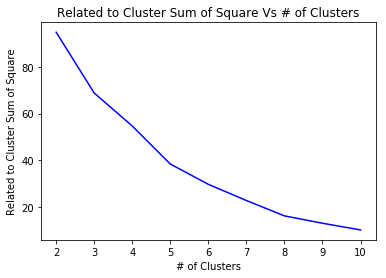

In [226]:
# Searching for elbow(optimal number of clusters)
K_range = range(2,11)
y =[]

for k in K_range:
    k_means = KMeans(n_clusters= k, random_state = 1, init = 'k-means++')
    k_means.fit(clust_train)
    labels=k_means.labels_
    y.append(k_means.inertia_)

plt.plot(K_range, y, color='blue')
plt.xlabel('# of Clusters')
plt.ylabel('Related to Cluster Sum of Square')
plt.title('Related to Cluster Sum of Square Vs # of Clusters')
plt.show()

In [230]:
X = clust_train

Kmean = KMeans(n_clusters=5)
Kmean.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [231]:
Kmean.labels_

array([0, 2, 0, 4, 1, 3, 0, 2, 2, 0, 0, 2, 0, 1, 0, 0, 2, 0, 2, 2, 1])

In [232]:
Kmean.cluster_centers_

array([[-0.36035489,  0.26036782, -0.39919399, -0.56695519, -0.47168571,
        -0.71897349, -0.18984396],
       [-0.14412825,  0.35335632, -0.43275732,  2.21347216,  2.25965094,
         0.98400787,  0.66591799],
       [-0.1400092 , -0.3861237 , -0.28661059,  0.08667713, -0.14915657,
         0.99348186, -0.30451114],
       [-0.47493289,  0.01239847,  3.86197108, -0.17339291, -0.21761242,
         0.47356216, -0.80204079],
       [ 3.38991648, -1.66139463,  2.0582322 , -0.69801565, -0.42416702,
        -1.35315053,  1.4442317 ]])